In [1]:
%config Completer.use_jedi = False

import numpy as np
from glob import glob
import pickle
import cv2
import matplotlib.pyplot as plt
import matplotlib 
import vis_image as vis
import tensorflow as tf
from commons import skeleton_utils
import os 
from scipy.io import loadmat
import random
import math
import transforms3d
import scipy.io as sio


/data/vcl/anirudh_rule_based/codes_2021/neurips_camera/SA3DHumanPose/image_to_latent_encoder/vis_image.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/data/vcl/sid/pradyumna/env/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/data/vcl/sid/pradyumna/env/lib/python3.6/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/data/vcl/sid/pradyumna/env/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 612

In [ ]:
new_order = [0, 2, 1, 3, 5, 4, 6, 8, 7, 9, 11, 10, 12, 14, 13, 15, 17, 16, 19, 18, 21, 20, 23, 22]

image_paths = {'source': []}
##mask
# mask_paths = {'source': []}
## joints
joints_2d = {'source': []}  
joints_3d = {'source': []} 
joints_3d_17 = {'source': []} 

## cam
cam_intrinsics = {'source': []}  
#cam_extrinsics = {'source': [], 'target': []}
#rotations = {'source': [], 'target': []} 
### smpl mesh   
betas = {'source': []}  
poses = {'source': []} 
trans = {'source': []}

genders = {'source': []}

In [3]:
def modified_mat(ske,name) :
   
    add_joint_raw = {'hips':0,
        'leftUpLeg':1,
        'rightUpLeg':2,
        'spine':3,
        'leftLeg':4,
        'rightLeg':5,
        'spine1':6,
        'leftFoot':7,
        'rightFoot':8,
        'spine2':9,
        'leftToeBase':10,
        'rightToeBase':11,
        'neck':12,
        'leftShoulder':13,
        'rightShoulder':14,
        'head':15,
        'leftArm':16,
        'rightArm':17,
        'leftForeArm':18,
        'rightForeArm':19,
        'leftHand':20,
        'rightHand':21,
        'leftHandIndex1':22,
        'rightHandIndex1':23}

    modified_joint_names = {'hips':0,
                            'neck':1,
                            'rightShoulder':2,
                            'rightForeArm':3,
                            'rightHand':4,  
                            'leftShoulder':5,
                            'leftForeArm':6,
                            'leftHand':7,
                            'head':8,
                            'rightUpLeg':9,
                            'rightLeg':10,
                            'rightFoot':11,
                            'rightToeBase':12,
                            'leftUpLeg':13,
                            'leftLeg':14,
                            'leftFoot':15,
                            'leftToeBase':16}

    if name == '2d':

        z = np.zeros((17,2))
        resized_frame = ske.copy()
        for key, value in modified_joint_names.items():
            z[value]=resized_frame[add_joint_raw[key]]

    if name == '3d':

        z = np.zeros((17,3))
        resized_frame = ske.copy()
        for key, value in modified_joint_names.items():
            z[value]=resized_frame[add_joint_raw[key]]

        one_col = z[:,[0]]
        two_col = z[:,[1]]
        three_col = z[:,[2]]
        z[:,[0]] = one_col
        z[:,[1]] = three_col
        z[:,[2]] = -two_col
#         z[0]=(z[9] + z[13])/2
        z = z - z[0]
        hip_right = np.array(z[9])
        hip_left = np.array(z[13])
        pelvis_pos = (hip_right + hip_left)/2 #interpolating pelvis
        z[0] = pelvis_pos
#         shoulder_left = np.array(z[5])
#         shoulder_right = np.array(z[2])
#         neck_pos_prior = z[1]
#         neck_pos = (shoulder_left + shoulder_right)/2 #interpolating neck
#         z[1] = neck_pos
#         del_neck = neck_pos - neck_pos_prior
#         z[8] = z[8] + del_neck #changing head_pos
        z = z - z[0] #making it root relative
        z = skeleton_utils.fit_skeleton_frame(z)
    return np.array(z)


def pose_rotate(points, theta, batch_size):
    theta = theta * np.pi / 180.0
    cos_vals = np.cos(theta)
    sin_vals = np.sin(theta)
    row_1 = np.concatenate([cos_vals, -sin_vals], axis=1)# 90 x 2
    row_2 = np.concatenate([sin_vals, cos_vals], axis=1)# 90 x 2
    row_12 = np.stack((row_1, row_2), axis=1)#90 x 2 x 2
    zero_size_row1x2 = np.zeros([batch_size, 1, 2])#90 x 1 x 2
    r1x2xZero = np.concatenate([row_12, zero_size_row1x2], axis=1)
    stacker = np.array([0.0, 0.0, 1.0])
    third_cols = np.reshape(np.tile(stacker, batch_size), [batch_size, 3])
    third_cols = np.expand_dims(third_cols, 2)
    rotation_matrix = np.concatenate([r1x2xZero, third_cols], axis=2)
    return np.matmul(points.reshape([points.shape[0], 17, 3]), rotation_matrix)


def rotate_y_axis(points,theta,batch_size):
    theta = theta * np.pi / 180
    cos_vals = np.cos(theta)#90 x 1
    sin_vals = np.sin(theta)
    zero_vals = np.zeros((batch_size,1))
    ones_vals = np.ones((batch_size,1))
    row_1 = np.concatenate([cos_vals, zero_vals],axis =1)#90 x2
    row_2 = np.concatenate([zero_vals ,ones_vals],axis=1)# 90 x 2
    row_12 = np.stack((row_1, row_2), axis=1)#90 x 2 x 2
    temp_3 = np.stack((-sin_vals,zero_vals),axis =2)#90 x 1 x 2
    temp_32 = np.concatenate([row_12,temp_3],axis = 1)#90 x 3 x 2
    third_cols = np.concatenate([sin_vals,zero_vals,cos_vals],axis=1)#90 x 3
    third_cols = np.expand_dims(third_cols, 2)
    rotation_matrix = np.concatenate([temp_32, third_cols], axis=2)
    return np.matmul(points.reshape([points.shape[0], 17, 3]), rotation_matrix)


def augment_pose_seq(pose_seq,z_limit=(0,360),y_limit=(-90,90)):
    pose_seq = np.expand_dims(pose_seq, axis=1)
    thetas = np.random.uniform(z_limit[0],z_limit[1], pose_seq.shape[0])
    thetas = np.stack([thetas]*pose_seq.shape[1], 1)
    k=[]
    for ct, xx in enumerate(thetas):
        k.append(pose_rotate(pose_seq[ct], np.expand_dims(thetas[ct], 1), pose_seq[ct].shape[0]))
    k = np.stack(k, 0)

    thetas = np.random.uniform(y_limit[0],y_limit[1], k.shape[0])
    thetas = np.stack([thetas]*k.shape[1], 1)
    p=[]
    for ct, xx in enumerate(thetas):
        p.append(rotate_y_axis(k[ct], np.expand_dims(thetas[ct], 1), k[ct].shape[0]))
    p = np.stack(p, 0)
    return k

In [4]:
def getExtrinsicBlender(T1):
    
    R_world2bcam = np.array([[0,   0,  1], [0,  -1,  0], [-1,  0,  0]]).T
   
    T_world2bcam = -1 * np.dot(R_world2bcam, T1)

    R_bcam2cv = np.array([[1,  0,  0], [0, -1,  0], [0,  0, -1]])

    R_world2cv = np.dot(R_bcam2cv, R_world2bcam)
    T_world2cv = np.dot(R_bcam2cv, T_world2bcam)

    RT = np.hstack((R_world2cv, T_world2cv))

    return RT

def rotateBody(RzBody, pelvisRotVec):
    angle = np.linalg.norm(pelvisRotVec)
    Rpelvis = transforms3d.axangles.axangle2mat(pelvisRotVec / angle, angle)
    globRotMat = np.dot(RzBody, Rpelvis)
    R90 = transforms3d.euler.euler2mat(np.pi / 2, 0, 0)
    globRotAx, globRotAngle = transforms3d.axangles.mat2axangle(np.dot(R90, globRotMat))
    globRotVec = globRotAx * globRotAngle
    return globRotVec

def is_not_okay(j0, j1, j2d_0, j2d_1):


    if j2d_0[15][1] > 112 or j2d_1[15][1] > 112:
        return True
            
    j0 = j0 - j0[0]
    j1 = j1 - j1[0]

    if(np.max(np.absolute(j0 - j1)) > 0.3):
        return False

    return True

def apply_zrot(zrot, pose):

    zrot = zrot - (np.pi/2.0)

    pose = pose[new_order]
    pose = pose *  [1.0, -1.0, -1.0]

    pose = np.reshape(pose, (72))

    source_RzBody = np.array((  (math.cos(zrot), -math.sin(zrot), 0),
                                (math.sin(zrot), math.cos(zrot), 0),
                                (0, 0, 1)))

    pose[0:3] = rotateBody(source_RzBody, pose[0:3] ) 



    pose = np.reshape(pose, (-1,3))
    pose = pose[new_order]
    pose = pose *  [1.0, -1.0, -1.0]
    return pose

In [5]:
data_root = '/data/vcl/anirudh_rule_based/remotes/128/adit/dataset_standardization/SURREAL/cmu/SURREAL_diff_crop/'
root_pos = np.array([-0.00217368, -0.24078917,  0.02858379])


for ttv in ["train/",]:
    for run in ["run0/",'run1/','run2/']:
        subject_list = os.listdir(data_root +ttv+run)        
        for ind, directory in enumerate(subject_list):            
            print(str(ind) + " of " + str(len(os.listdir(data_root + ttv + run))) + " in run " + run)
            if not os.path.isdir(data_root + ttv + run + directory):
                continue
            sub_dirs = os.listdir(data_root + ttv + run + directory)
            sub_dirs = [f[:-7] for f in sub_dirs if f.endswith(".pickle")]
#             if not os.path.isdir("masks/" + ttv + run + directory):
#                 continue
            for person_dir in sub_dirs:
                annots = pickle.load(open(data_root + ttv + run + directory + "/" + person_dir + ".pickle",'rb'),encoding="latin1")
                camLoc = annots["camLoc"]
                RT = getExtrinsicBlender(camLoc)
                ##Add zrot similar to camLoc but from other directory
                a = loadmat((data_root + ttv + run + directory + "/" + person_dir + "_info.mat").replace('SURREAL_diff_crop/',''))
                zrot = a['zrot']
                zrot = zrot[0][0]
                gender = a["gender"][0][0]
#                 if not os.path.isdir("masks/" + ttv + run + directory + "/" + person_dir):
#                     break
                this_person = 0
                for i, frame in enumerate(annots["frames"]):
                    #ind += 1
                    other_i = random.randint(0, len(annots["frames"]) - 1)
                    times = 0
                    while(is_not_okay(annots["joints_3d"][i], annots["joints_3d"][other_i], annots["joints_2d"][i], annots["joints_3d"][other_i] )):
                        other_i = random.randint(0, len(annots["frames"]) - 1)
                        times += 1
                        if(times>20):
                            break
                    image_name = "image_{:03d}.jpg".format(frame)
                    image_paths["source"].append(data_root + ttv + run + directory + "/" + person_dir + "/" + image_name)

                    j_2d = annots["joints_2d"][i]
                    j_2d = j_2d[new_order]
                    joints_2d["source"].append(j_2d)
                    cam_intrinsics["source"].append(annots["intrinsics"][i])
                    #cam_extrinsics["source"].append(camLoc)
                    #rotations["source"].append(zrot)
                    genders["source"].append(gender)
                    betas["source"].append(annots["shapes"][i])
                    pose = annots["smpl_poses"][i]
                    pose = apply_zrot(zrot, pose)
                    poses["source"].append(pose)
                    extra_tr = np.array([RT[0,3], RT[1,3], RT[2,3]], dtype=np.float32)
                    trans_ = ((annots["joints_3d"][i][0] - root_pos)[[2,1,0]]*[-1.0, 1.0, -1.0] ) + extra_tr
                    trans["source"].append(trans_)
                    j_3d = annots["joints_3d"][i]
                    j_3d = j_3d[new_order]
                    j_3d = j_3d[:, [2, 1, 0]]
                    j_3d = j_3d * [-1.0, 1.0, -1.0]
                    j_3d = j_3d + extra_tr
                    joints_3d["source"].append(j_3d)
                    j_3d_17 = j_3d.reshape((24,3))
                    j_3d_17=modified_mat(j_3d_17,'3d')
                    j_3d_17 = np.squeeze(augment_pose_seq(np.expand_dims(j_3d_17,0) , z_limit=(-90,-90),y_limit=(0,0)))
                    joints_3d_17["source"].append(j_3d_17)
                    assert len(image_paths["source"]) == len(joints_3d_17["source"]), "Image list and pose list should have same length"
                    #masks["source"].append(annots["masks"][i])
                    #mask = annots["masks"][i] * 10
#                     mask_path = "masks/" + ttv + run + directory + "/" +  person_dir + "/" + image_name
#                     mask_paths["source"].append(mask_path)

                    #imsave(mask_path, mask)

train_dict = {  'image_paths': image_paths,
                'joints_2d': joints_2d,
                'joints_3d': joints_3d,
                'joints_3d_17': joints_3d_17,
                'cam_intrinsics':cam_intrinsics,
                'betas':betas,
                'poses': poses, 
                'trans' : trans,
                'genders' : genders,
#                 'mask_paths': mask_paths
            }


                   
savedict = { 'train':train_dict }  

print("Saving " + ttv[:-1])

with open('/data/vcl/anirudh_rule_based/codes_2020/data/surreal_data_vneck/surreal_train.pkl', 'wb') as f:
    pickle.dump(savedict, f, pickle.HIGHEST_PROTOCOL)




0 of 1952 in run run0/
1 of 1952 in run run0/
2 of 1952 in run run0/
3 of 1952 in run run0/
4 of 1952 in run run0/
5 of 1952 in run run0/
6 of 1952 in run run0/
7 of 1952 in run run0/
8 of 1952 in run run0/
9 of 1952 in run run0/
10 of 1952 in run run0/
11 of 1952 in run run0/
12 of 1952 in run run0/
13 of 1952 in run run0/
14 of 1952 in run run0/
15 of 1952 in run run0/
16 of 1952 in run run0/
17 of 1952 in run run0/
18 of 1952 in run run0/
19 of 1952 in run run0/
20 of 1952 in run run0/
21 of 1952 in run run0/
22 of 1952 in run run0/
23 of 1952 in run run0/
24 of 1952 in run run0/
25 of 1952 in run run0/
26 of 1952 in run run0/
27 of 1952 in run run0/
28 of 1952 in run run0/
29 of 1952 in run run0/
30 of 1952 in run run0/
31 of 1952 in run run0/
32 of 1952 in run run0/
33 of 1952 in run run0/
34 of 1952 in run run0/
35 of 1952 in run run0/
36 of 1952 in run run0/
37 of 1952 in run run0/
38 of 1952 in run run0/
39 of 1952 in run run0/
40 of 1952 in run run0/
41 of 1952 in run run0/
42

333 of 1952 in run run0/
334 of 1952 in run run0/
335 of 1952 in run run0/
336 of 1952 in run run0/
337 of 1952 in run run0/
338 of 1952 in run run0/
339 of 1952 in run run0/
340 of 1952 in run run0/
341 of 1952 in run run0/
342 of 1952 in run run0/
343 of 1952 in run run0/
344 of 1952 in run run0/
345 of 1952 in run run0/
346 of 1952 in run run0/
347 of 1952 in run run0/
348 of 1952 in run run0/
349 of 1952 in run run0/
350 of 1952 in run run0/
351 of 1952 in run run0/
352 of 1952 in run run0/
353 of 1952 in run run0/
354 of 1952 in run run0/
355 of 1952 in run run0/
356 of 1952 in run run0/
357 of 1952 in run run0/
358 of 1952 in run run0/
359 of 1952 in run run0/
360 of 1952 in run run0/
361 of 1952 in run run0/
362 of 1952 in run run0/
363 of 1952 in run run0/
364 of 1952 in run run0/
365 of 1952 in run run0/
366 of 1952 in run run0/
367 of 1952 in run run0/
368 of 1952 in run run0/
369 of 1952 in run run0/
370 of 1952 in run run0/
371 of 1952 in run run0/
372 of 1952 in run run0/


661 of 1952 in run run0/
662 of 1952 in run run0/
663 of 1952 in run run0/
664 of 1952 in run run0/
665 of 1952 in run run0/
666 of 1952 in run run0/
667 of 1952 in run run0/
668 of 1952 in run run0/
669 of 1952 in run run0/
670 of 1952 in run run0/
671 of 1952 in run run0/
672 of 1952 in run run0/
673 of 1952 in run run0/
674 of 1952 in run run0/
675 of 1952 in run run0/
676 of 1952 in run run0/
677 of 1952 in run run0/
678 of 1952 in run run0/
679 of 1952 in run run0/
680 of 1952 in run run0/
681 of 1952 in run run0/
682 of 1952 in run run0/
683 of 1952 in run run0/
684 of 1952 in run run0/
685 of 1952 in run run0/
686 of 1952 in run run0/
687 of 1952 in run run0/
688 of 1952 in run run0/
689 of 1952 in run run0/
690 of 1952 in run run0/
691 of 1952 in run run0/
692 of 1952 in run run0/
693 of 1952 in run run0/
694 of 1952 in run run0/
695 of 1952 in run run0/
696 of 1952 in run run0/
697 of 1952 in run run0/
698 of 1952 in run run0/
699 of 1952 in run run0/
700 of 1952 in run run0/


989 of 1952 in run run0/
990 of 1952 in run run0/
991 of 1952 in run run0/
992 of 1952 in run run0/
993 of 1952 in run run0/
994 of 1952 in run run0/
995 of 1952 in run run0/
996 of 1952 in run run0/
997 of 1952 in run run0/
998 of 1952 in run run0/
999 of 1952 in run run0/
1000 of 1952 in run run0/
1001 of 1952 in run run0/
1002 of 1952 in run run0/
1003 of 1952 in run run0/
1004 of 1952 in run run0/
1005 of 1952 in run run0/
1006 of 1952 in run run0/
1007 of 1952 in run run0/
1008 of 1952 in run run0/
1009 of 1952 in run run0/
1010 of 1952 in run run0/
1011 of 1952 in run run0/
1012 of 1952 in run run0/
1013 of 1952 in run run0/
1014 of 1952 in run run0/
1015 of 1952 in run run0/
1016 of 1952 in run run0/
1017 of 1952 in run run0/
1018 of 1952 in run run0/
1019 of 1952 in run run0/
1020 of 1952 in run run0/
1021 of 1952 in run run0/
1022 of 1952 in run run0/
1023 of 1952 in run run0/
1024 of 1952 in run run0/
1025 of 1952 in run run0/
1026 of 1952 in run run0/
1027 of 1952 in run run

1305 of 1952 in run run0/
1306 of 1952 in run run0/
1307 of 1952 in run run0/
1308 of 1952 in run run0/
1309 of 1952 in run run0/
1310 of 1952 in run run0/
1311 of 1952 in run run0/
1312 of 1952 in run run0/
1313 of 1952 in run run0/
1314 of 1952 in run run0/
1315 of 1952 in run run0/
1316 of 1952 in run run0/
1317 of 1952 in run run0/
1318 of 1952 in run run0/
1319 of 1952 in run run0/
1320 of 1952 in run run0/
1321 of 1952 in run run0/
1322 of 1952 in run run0/
1323 of 1952 in run run0/
1324 of 1952 in run run0/
1325 of 1952 in run run0/
1326 of 1952 in run run0/
1327 of 1952 in run run0/
1328 of 1952 in run run0/
1329 of 1952 in run run0/
1330 of 1952 in run run0/
1331 of 1952 in run run0/
1332 of 1952 in run run0/
1333 of 1952 in run run0/
1334 of 1952 in run run0/
1335 of 1952 in run run0/
1336 of 1952 in run run0/
1337 of 1952 in run run0/
1338 of 1952 in run run0/
1339 of 1952 in run run0/
1340 of 1952 in run run0/
1341 of 1952 in run run0/
1342 of 1952 in run run0/
1343 of 1952

1621 of 1952 in run run0/
1622 of 1952 in run run0/
1623 of 1952 in run run0/
1624 of 1952 in run run0/
1625 of 1952 in run run0/
1626 of 1952 in run run0/
1627 of 1952 in run run0/
1628 of 1952 in run run0/
1629 of 1952 in run run0/
1630 of 1952 in run run0/
1631 of 1952 in run run0/
1632 of 1952 in run run0/
1633 of 1952 in run run0/
1634 of 1952 in run run0/
1635 of 1952 in run run0/
1636 of 1952 in run run0/
1637 of 1952 in run run0/
1638 of 1952 in run run0/
1639 of 1952 in run run0/
1640 of 1952 in run run0/
1641 of 1952 in run run0/
1642 of 1952 in run run0/
1643 of 1952 in run run0/
1644 of 1952 in run run0/
1645 of 1952 in run run0/
1646 of 1952 in run run0/
1647 of 1952 in run run0/
1648 of 1952 in run run0/
1649 of 1952 in run run0/
1650 of 1952 in run run0/
1651 of 1952 in run run0/
1652 of 1952 in run run0/
1653 of 1952 in run run0/
1654 of 1952 in run run0/
1655 of 1952 in run run0/
1656 of 1952 in run run0/
1657 of 1952 in run run0/
1658 of 1952 in run run0/
1659 of 1952

1937 of 1952 in run run0/
1938 of 1952 in run run0/
1939 of 1952 in run run0/
1940 of 1952 in run run0/
1941 of 1952 in run run0/
1942 of 1952 in run run0/
1943 of 1952 in run run0/
1944 of 1952 in run run0/
1945 of 1952 in run run0/
1946 of 1952 in run run0/
1947 of 1952 in run run0/
1948 of 1952 in run run0/
1949 of 1952 in run run0/
1950 of 1952 in run run0/
1951 of 1952 in run run0/
0 of 1913 in run run1/
1 of 1913 in run run1/
2 of 1913 in run run1/
3 of 1913 in run run1/
4 of 1913 in run run1/
5 of 1913 in run run1/
6 of 1913 in run run1/
7 of 1913 in run run1/
8 of 1913 in run run1/
9 of 1913 in run run1/
10 of 1913 in run run1/
11 of 1913 in run run1/
12 of 1913 in run run1/
13 of 1913 in run run1/
14 of 1913 in run run1/
15 of 1913 in run run1/
16 of 1913 in run run1/
17 of 1913 in run run1/
18 of 1913 in run run1/
19 of 1913 in run run1/
20 of 1913 in run run1/
21 of 1913 in run run1/
22 of 1913 in run run1/
23 of 1913 in run run1/
24 of 1913 in run run1/
25 of 1913 in run ru

318 of 1913 in run run1/
319 of 1913 in run run1/
320 of 1913 in run run1/
321 of 1913 in run run1/
322 of 1913 in run run1/
323 of 1913 in run run1/
324 of 1913 in run run1/
325 of 1913 in run run1/
326 of 1913 in run run1/
327 of 1913 in run run1/
328 of 1913 in run run1/
329 of 1913 in run run1/
330 of 1913 in run run1/
331 of 1913 in run run1/
332 of 1913 in run run1/
333 of 1913 in run run1/
334 of 1913 in run run1/
335 of 1913 in run run1/
336 of 1913 in run run1/
337 of 1913 in run run1/
338 of 1913 in run run1/
339 of 1913 in run run1/
340 of 1913 in run run1/
341 of 1913 in run run1/
342 of 1913 in run run1/
343 of 1913 in run run1/
344 of 1913 in run run1/
345 of 1913 in run run1/
346 of 1913 in run run1/
347 of 1913 in run run1/
348 of 1913 in run run1/
349 of 1913 in run run1/
350 of 1913 in run run1/
351 of 1913 in run run1/
352 of 1913 in run run1/
353 of 1913 in run run1/
354 of 1913 in run run1/
355 of 1913 in run run1/
356 of 1913 in run run1/
357 of 1913 in run run1/


647 of 1913 in run run1/
648 of 1913 in run run1/
649 of 1913 in run run1/
650 of 1913 in run run1/
651 of 1913 in run run1/
652 of 1913 in run run1/
653 of 1913 in run run1/
654 of 1913 in run run1/
655 of 1913 in run run1/
656 of 1913 in run run1/
657 of 1913 in run run1/
658 of 1913 in run run1/
659 of 1913 in run run1/
660 of 1913 in run run1/
661 of 1913 in run run1/
662 of 1913 in run run1/
663 of 1913 in run run1/
664 of 1913 in run run1/
665 of 1913 in run run1/
666 of 1913 in run run1/
667 of 1913 in run run1/
668 of 1913 in run run1/
669 of 1913 in run run1/
670 of 1913 in run run1/
671 of 1913 in run run1/
672 of 1913 in run run1/
673 of 1913 in run run1/
674 of 1913 in run run1/
675 of 1913 in run run1/
676 of 1913 in run run1/
677 of 1913 in run run1/
678 of 1913 in run run1/
679 of 1913 in run run1/
680 of 1913 in run run1/
681 of 1913 in run run1/
682 of 1913 in run run1/
683 of 1913 in run run1/
684 of 1913 in run run1/
685 of 1913 in run run1/
686 of 1913 in run run1/


975 of 1913 in run run1/
976 of 1913 in run run1/
977 of 1913 in run run1/
978 of 1913 in run run1/
979 of 1913 in run run1/
980 of 1913 in run run1/
981 of 1913 in run run1/
982 of 1913 in run run1/
983 of 1913 in run run1/
984 of 1913 in run run1/
985 of 1913 in run run1/
986 of 1913 in run run1/
987 of 1913 in run run1/
988 of 1913 in run run1/
989 of 1913 in run run1/
990 of 1913 in run run1/
991 of 1913 in run run1/
992 of 1913 in run run1/
993 of 1913 in run run1/
994 of 1913 in run run1/
995 of 1913 in run run1/
996 of 1913 in run run1/
997 of 1913 in run run1/
998 of 1913 in run run1/
999 of 1913 in run run1/
1000 of 1913 in run run1/
1001 of 1913 in run run1/
1002 of 1913 in run run1/
1003 of 1913 in run run1/
1004 of 1913 in run run1/
1005 of 1913 in run run1/
1006 of 1913 in run run1/
1007 of 1913 in run run1/
1008 of 1913 in run run1/
1009 of 1913 in run run1/
1010 of 1913 in run run1/
1011 of 1913 in run run1/
1012 of 1913 in run run1/
1013 of 1913 in run run1/
1014 of 191

1293 of 1913 in run run1/
1294 of 1913 in run run1/
1295 of 1913 in run run1/
1296 of 1913 in run run1/
1297 of 1913 in run run1/
1298 of 1913 in run run1/
1299 of 1913 in run run1/
1300 of 1913 in run run1/
1301 of 1913 in run run1/
1302 of 1913 in run run1/
1303 of 1913 in run run1/
1304 of 1913 in run run1/
1305 of 1913 in run run1/
1306 of 1913 in run run1/
1307 of 1913 in run run1/
1308 of 1913 in run run1/
1309 of 1913 in run run1/
1310 of 1913 in run run1/
1311 of 1913 in run run1/
1312 of 1913 in run run1/
1313 of 1913 in run run1/
1314 of 1913 in run run1/
1315 of 1913 in run run1/
1316 of 1913 in run run1/
1317 of 1913 in run run1/
1318 of 1913 in run run1/
1319 of 1913 in run run1/
1320 of 1913 in run run1/
1321 of 1913 in run run1/
1322 of 1913 in run run1/
1323 of 1913 in run run1/
1324 of 1913 in run run1/
1325 of 1913 in run run1/
1326 of 1913 in run run1/
1327 of 1913 in run run1/
1328 of 1913 in run run1/
1329 of 1913 in run run1/
1330 of 1913 in run run1/
1331 of 1913

1609 of 1913 in run run1/
1610 of 1913 in run run1/
1611 of 1913 in run run1/
1612 of 1913 in run run1/
1613 of 1913 in run run1/
1614 of 1913 in run run1/
1615 of 1913 in run run1/
1616 of 1913 in run run1/
1617 of 1913 in run run1/
1618 of 1913 in run run1/
1619 of 1913 in run run1/
1620 of 1913 in run run1/
1621 of 1913 in run run1/
1622 of 1913 in run run1/
1623 of 1913 in run run1/
1624 of 1913 in run run1/
1625 of 1913 in run run1/
1626 of 1913 in run run1/
1627 of 1913 in run run1/
1628 of 1913 in run run1/
1629 of 1913 in run run1/
1630 of 1913 in run run1/
1631 of 1913 in run run1/
1632 of 1913 in run run1/
1633 of 1913 in run run1/
1634 of 1913 in run run1/
1635 of 1913 in run run1/
1636 of 1913 in run run1/
1637 of 1913 in run run1/
1638 of 1913 in run run1/
1639 of 1913 in run run1/
1640 of 1913 in run run1/
1641 of 1913 in run run1/
1642 of 1913 in run run1/
1643 of 1913 in run run1/
1644 of 1913 in run run1/
1645 of 1913 in run run1/
1646 of 1913 in run run1/
1647 of 1913

13 of 1952 in run run2/
14 of 1952 in run run2/
15 of 1952 in run run2/
16 of 1952 in run run2/
17 of 1952 in run run2/
18 of 1952 in run run2/
19 of 1952 in run run2/
20 of 1952 in run run2/
21 of 1952 in run run2/
22 of 1952 in run run2/
23 of 1952 in run run2/
24 of 1952 in run run2/
25 of 1952 in run run2/
26 of 1952 in run run2/
27 of 1952 in run run2/
28 of 1952 in run run2/
29 of 1952 in run run2/
30 of 1952 in run run2/
31 of 1952 in run run2/
32 of 1952 in run run2/
33 of 1952 in run run2/
34 of 1952 in run run2/
35 of 1952 in run run2/
36 of 1952 in run run2/
37 of 1952 in run run2/
38 of 1952 in run run2/
39 of 1952 in run run2/
40 of 1952 in run run2/
41 of 1952 in run run2/
42 of 1952 in run run2/
43 of 1952 in run run2/
44 of 1952 in run run2/
45 of 1952 in run run2/
46 of 1952 in run run2/
47 of 1952 in run run2/
48 of 1952 in run run2/
49 of 1952 in run run2/
50 of 1952 in run run2/
51 of 1952 in run run2/
52 of 1952 in run run2/
53 of 1952 in run run2/
54 of 1952 in ru

346 of 1952 in run run2/
347 of 1952 in run run2/
348 of 1952 in run run2/
349 of 1952 in run run2/
350 of 1952 in run run2/
351 of 1952 in run run2/
352 of 1952 in run run2/
353 of 1952 in run run2/
354 of 1952 in run run2/
355 of 1952 in run run2/
356 of 1952 in run run2/
357 of 1952 in run run2/
358 of 1952 in run run2/
359 of 1952 in run run2/
360 of 1952 in run run2/
361 of 1952 in run run2/
362 of 1952 in run run2/
363 of 1952 in run run2/
364 of 1952 in run run2/
365 of 1952 in run run2/
366 of 1952 in run run2/
367 of 1952 in run run2/
368 of 1952 in run run2/
369 of 1952 in run run2/
370 of 1952 in run run2/
371 of 1952 in run run2/
372 of 1952 in run run2/
373 of 1952 in run run2/
374 of 1952 in run run2/
375 of 1952 in run run2/
376 of 1952 in run run2/
377 of 1952 in run run2/
378 of 1952 in run run2/
379 of 1952 in run run2/
380 of 1952 in run run2/
381 of 1952 in run run2/
382 of 1952 in run run2/
383 of 1952 in run run2/
384 of 1952 in run run2/
385 of 1952 in run run2/


674 of 1952 in run run2/
675 of 1952 in run run2/
676 of 1952 in run run2/
677 of 1952 in run run2/
678 of 1952 in run run2/
679 of 1952 in run run2/
680 of 1952 in run run2/
681 of 1952 in run run2/
682 of 1952 in run run2/
683 of 1952 in run run2/
684 of 1952 in run run2/
685 of 1952 in run run2/
686 of 1952 in run run2/
687 of 1952 in run run2/
688 of 1952 in run run2/
689 of 1952 in run run2/
690 of 1952 in run run2/
691 of 1952 in run run2/
692 of 1952 in run run2/
693 of 1952 in run run2/
694 of 1952 in run run2/
695 of 1952 in run run2/
696 of 1952 in run run2/
697 of 1952 in run run2/
698 of 1952 in run run2/
699 of 1952 in run run2/
700 of 1952 in run run2/
701 of 1952 in run run2/
702 of 1952 in run run2/
703 of 1952 in run run2/
704 of 1952 in run run2/
705 of 1952 in run run2/
706 of 1952 in run run2/
707 of 1952 in run run2/
708 of 1952 in run run2/
709 of 1952 in run run2/
710 of 1952 in run run2/
711 of 1952 in run run2/
712 of 1952 in run run2/
713 of 1952 in run run2/


1002 of 1952 in run run2/
1003 of 1952 in run run2/
1004 of 1952 in run run2/
1005 of 1952 in run run2/
1006 of 1952 in run run2/
1007 of 1952 in run run2/
1008 of 1952 in run run2/
1009 of 1952 in run run2/
1010 of 1952 in run run2/
1011 of 1952 in run run2/
1012 of 1952 in run run2/
1013 of 1952 in run run2/
1014 of 1952 in run run2/
1015 of 1952 in run run2/
1016 of 1952 in run run2/
1017 of 1952 in run run2/
1018 of 1952 in run run2/
1019 of 1952 in run run2/
1020 of 1952 in run run2/
1021 of 1952 in run run2/
1022 of 1952 in run run2/
1023 of 1952 in run run2/
1024 of 1952 in run run2/
1025 of 1952 in run run2/
1026 of 1952 in run run2/
1027 of 1952 in run run2/
1028 of 1952 in run run2/
1029 of 1952 in run run2/
1030 of 1952 in run run2/
1031 of 1952 in run run2/
1032 of 1952 in run run2/
1033 of 1952 in run run2/
1034 of 1952 in run run2/
1035 of 1952 in run run2/
1036 of 1952 in run run2/
1037 of 1952 in run run2/
1038 of 1952 in run run2/
1039 of 1952 in run run2/
1040 of 1952

1318 of 1952 in run run2/
1319 of 1952 in run run2/
1320 of 1952 in run run2/
1321 of 1952 in run run2/
1322 of 1952 in run run2/
1323 of 1952 in run run2/
1324 of 1952 in run run2/
1325 of 1952 in run run2/
1326 of 1952 in run run2/
1327 of 1952 in run run2/
1328 of 1952 in run run2/
1329 of 1952 in run run2/
1330 of 1952 in run run2/
1331 of 1952 in run run2/
1332 of 1952 in run run2/
1333 of 1952 in run run2/
1334 of 1952 in run run2/
1335 of 1952 in run run2/
1336 of 1952 in run run2/
1337 of 1952 in run run2/
1338 of 1952 in run run2/
1339 of 1952 in run run2/
1340 of 1952 in run run2/
1341 of 1952 in run run2/
1342 of 1952 in run run2/
1343 of 1952 in run run2/
1344 of 1952 in run run2/
1345 of 1952 in run run2/
1346 of 1952 in run run2/
1347 of 1952 in run run2/
1348 of 1952 in run run2/
1349 of 1952 in run run2/
1350 of 1952 in run run2/
1351 of 1952 in run run2/
1352 of 1952 in run run2/
1353 of 1952 in run run2/
1354 of 1952 in run run2/
1355 of 1952 in run run2/
1356 of 1952

1635 of 1952 in run run2/
1636 of 1952 in run run2/
1637 of 1952 in run run2/
1638 of 1952 in run run2/
1639 of 1952 in run run2/
1640 of 1952 in run run2/
1641 of 1952 in run run2/
1642 of 1952 in run run2/
1643 of 1952 in run run2/
1644 of 1952 in run run2/
1645 of 1952 in run run2/
1646 of 1952 in run run2/
1647 of 1952 in run run2/
1648 of 1952 in run run2/
1649 of 1952 in run run2/
1650 of 1952 in run run2/
1651 of 1952 in run run2/
1652 of 1952 in run run2/
1653 of 1952 in run run2/
1654 of 1952 in run run2/
1655 of 1952 in run run2/
1656 of 1952 in run run2/
1657 of 1952 in run run2/
1658 of 1952 in run run2/
1659 of 1952 in run run2/
1660 of 1952 in run run2/
1661 of 1952 in run run2/
1662 of 1952 in run run2/
1663 of 1952 in run run2/
1664 of 1952 in run run2/
1665 of 1952 in run run2/
1666 of 1952 in run run2/
1667 of 1952 in run run2/
1668 of 1952 in run run2/
1669 of 1952 in run run2/
1670 of 1952 in run run2/
1671 of 1952 in run run2/
1672 of 1952 in run run2/
1673 of 1952

1951 of 1952 in run run2/
Saving train


In [6]:
assert len(image_paths["source"]) == len(joints_3d_17["source"])


In [7]:
len(image_paths["source"])

4986711

In [8]:
len(joints_3d_17["source"])

4986711

In [2]:
data = pickle.load(open('/data/vcl/anirudh_rule_based/codes_2020/data/surreal_data_vneck/surreal_train.pkl','rb'),encoding='latin1')


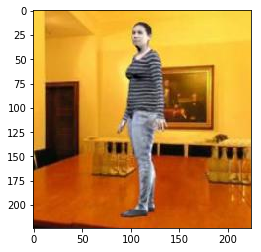

In [10]:
plt.imshow(cv2.imread(data['train']['image_paths']['source'][9999])[:,:,::-1])

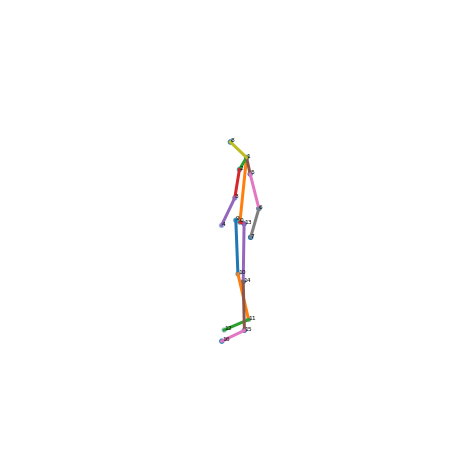

In [11]:
poses_3d = data['train']['joints_3d_17']['source'][9999]
fig = vis.get_figure()
ax = vis.get_ax(fig=fig,joints_3d=poses_3d)
vis.plot_skeleton_and_scatter(ax=ax,ske=poses_3d)

In [7]:


images_path = data['train']['image_paths']['source'][4_000_000:]
poses = data['train']['joints_3d_17']['source'][4_000_000:]


train_dict= {'images_path' : images_path,
             'poses_3d':poses
            }

sio.savemat('/data//vcl/anirudh_rule_based/codes_2020/data/surreal_data_vneck/surreal_train_5.mat',train_dict)

In [6]:
data = sio.loadmat('/data//vcl/anirudh_rule_based/codes_2020/data/surreal_data_vneck/surreal_train.mat')

In [7]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images_path', 'poses_3d'])

In [8]:
len(data['train']['image_paths']['source'])

4986711